batch size : (64->) 128  
epoch 40  
feature extractor : efficientnet b0  
augmentation : resize(224x224)   

score : 0.84197 (previous best : 0.8326)

## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms


from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [16]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [6]:
os.chdir('/content/drive/MyDrive')

In [7]:
os.getcwd()

'/content/drive/MyDrive'

In [8]:
df = pd.read_csv('./train.csv')

In [9]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [10]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

In [11]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

66251 10637


## Get Vocabulary

In [12]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [13]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


In [14]:
with open('train.pickle', 'rb') as data:
    train_img = pickle.load(data)  
with open('test.pickle', 'rb') as data:
    test_img = pickle.load(data)  

In [15]:
train_img2 = []

for i in train.index:
  train_img2.append(train_img[i])
val_img = []

for i in val.index:
  val_img.append(train_img[i])

## CustomDataset

In [21]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, train_mode=True):
        self.img_list = img_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        image = self.img_list[index]
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            #transforms.RandomAdjustSharpness(2),
            #transforms.GaussianBlur(kernel_size = (5,5), sigma = (0.1, 2)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ]) 
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [22]:
train_dataset = CustomDataset(img_list=train_img2, label_list=train['label'].values)
#train_dataset = CustomDataset(train['img_path'].values, train['label'].values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(img_list=val_img, label_list=val['label'].values)
#val_dataset = CustomDataset(val['img_path'].values, val['label'].values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [23]:
len(train_dataset)

66251

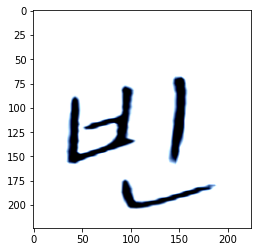

In [24]:
plt.imshow(train_dataset[2][0].permute(1,2,0))

In [25]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([128, 3, 224, 224]) ('마흔', '선거', '목표', '기구', '챈', '결론', '벌', '캐나다', '차창', '테러', '색', '깔리다', '솔직히', '쓺', '명', '불필요하다', '년', '등', '족', '의욕', '현재', '동', '권위', '탁자', '감사하다', '탓', '어때', '사이사이', '텟', '나', '간편하다', '조절하다', '웨이터', '숑', '댄', '기', '공격하다', '두드리다', '색', '뻘', '소원', '햇볕', '린', '블라우스', '시청률', '아시아', '쯔', '모두', '셤', '죕', '등산로', '기관', '목', '근거하다', '밤하늘', '휨', '텍', '달력', '바라보다', '댓', '그나마', '켭', '쇠', '단편', '숙제', '턱', '스웨터', '참석', '행동하다', '턱', '모', '세로', '기울다', '헤아리다', '삶다', '본질', '연구실', '홋', '전', '섬', '꿉', '표정', '맘대로', '분홍색', '배', '뇬', '사장', '창밖', '켈', '힉', '에', '개다', '옆', '윰', '불확실하다', '내부', '일요일', '향상되다', '우리나라', '꺾', '젯', '옷', '그러나', '살아나다', '느낌', '지혜', '이내', '쨀', '원인', '읏', '이제', '확립하다', '엣', '핵심', '물속', '뜯다', '차차', '와', '꿨', '기구', '기초', '한', '섀', '오다', '친', '짐작하다', '른', '갑')


## Model Define

In [26]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.9 MB/s eta 0:00:00


In [27]:
import timm

In [28]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        
        # CNN Backbone = 사전학습된 Efficientnet 활용
        # https://arxiv.org/abs/1905.11946
        eff0 = timm.create_model(model_name='efficientnet_b0', pretrained=True)
        # CNN Feature Extract
        eff_modules = list(eff0.children())[:-2]
        self.feature_extract = nn.Sequential(
            *eff_modules,
            
        )

        self.linear1 = nn.Linear(8960, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [29]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [30]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [31]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train

In [33]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [34]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [35]:
model = RecognitionModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [5.19260] Val CTC Loss : [1.71336]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [1.53565] Val CTC Loss : [0.52389]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.63757] Val CTC Loss : [0.31701]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.33764] Val CTC Loss : [0.20695]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.23155] Val CTC Loss : [0.22570]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.20639] Val CTC Loss : [0.19777]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.19204] Val CTC Loss : [0.21100]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.20180] Val CTC Loss : [0.17310]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.17844] Val CTC Loss : [0.19712]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.17736] Val CTC Loss : [0.21238]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.18581] Val CTC Loss : [0.23519]
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.06735] Val CTC Loss : [0.09440]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.02921] Val CTC Loss : [0.09408]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.02371] Val CTC Loss : [0.08549]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.02614] Val CTC Loss : [0.10126]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.03610] Val CTC Loss : [0.12385]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.04254] Val CTC Loss : [0.09291]
Epoch 00017: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.01404] Val CTC Loss : [0.07315]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.00694] Val CTC Loss : [0.06564]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00466] Val CTC Loss : [0.06809]


In [37]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [0.00804] Val CTC Loss : [0.07001]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [0.00865] Val CTC Loss : [0.06962]
Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.00375] Val CTC Loss : [0.06281]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.00207] Val CTC Loss : [0.06143]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.00155] Val CTC Loss : [0.05786]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.00144] Val CTC Loss : [0.06133]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.00167] Val CTC Loss : [0.06138]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.00110] Val CTC Loss : [0.05936]
Epoch 00028: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.00086] Val CTC Loss : [0.05848]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.00064] Val CTC Loss : [0.05833]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.00061] Val CTC Loss : [0.06313]
Epoch 00031: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.00047] Val CTC Loss : [0.06040]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.00040] Val CTC Loss : [0.05858]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.00041] Val CTC Loss : [0.05810]
Epoch 00034: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.00035] Val CTC Loss : [0.05702]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.00031] Val CTC Loss : [0.05711]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.00031] Val CTC Loss : [0.05696]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.00029] Val CTC Loss : [0.05860]
Epoch 00038: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.00026] Val CTC Loss : [0.05717]


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00028] Val CTC Loss : [0.05710]


In [38]:
torch.save(infer_model.state_dict(), 'model_0108_40_128.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model_1231.pt'))
model.eval()
model = model.to(device)

## Inference

In [39]:
test = pd.read_csv('./test.csv')

In [40]:
test_dataset = CustomDataset(test_img, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

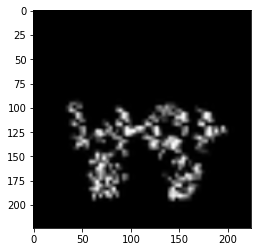

In [43]:
plt.imshow(test_dataset[0][0], cmap = 'Greys')

In [44]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [46]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/580 [00:00<?, ?it/s]

## Submission

In [47]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [48]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [49]:
submit.to_csv('/content/drive/MyDrive/submission.csv', index=False)